## Import

In [1]:
pip install sunpath

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import sunpath as sp

## Data

In [3]:
dataPath = '../data/'

# weatherPath = dataPath + 'SolarPilot/USA CA Daggett (TMY2).csv'
weatherPath = dataPath + 'Tonatiuh/Seville_GTER_TMY.csv'

etaName = "Polar"
# etaPath = dataPath + 'SolarPilot/Polar-20MW-results-10d.csv'
etaPath = dataPath + 'Tonatiuh/etaPolar.csv'

# etaName = "Surround"
# etaPath = dataPath + 'SolarPilot/Surround-100MW-results-10d.csv'
# etaPath = dataPath + 'Tonatiuh/etaSurround.csv'

In [4]:
# clear sky irradiance
# location = sp.Location(
#     "Daggett, CA", 
#     sp.PointGeographic(latitude=34.9*sp.degree, longitude=-116.8*sp.degree),
#     sp.timedelta(hours=-8)
# )
location = sp.Location(
    "Seville, ES", 
    sp.PointGeographic(latitude=37.411667*sp.degree, longitude=-6.005833*sp.degree),
    sp.timedelta(hours=0)
)
sunCalculator = sp.SunCalculator(location)
sunTemporal = sp.SunTemporal(sunCalculator)
sunTemporal.sampleYear(2021, sp.timedelta(minutes=60), sp.irradianceIneichen)

In [5]:
# measured irradiance
sunCalculator = sp.SunCalculator()
sunTemporal = sp.SunTemporal(sunCalculator)
# sunTemporal.readTMY(weatherPath, tMid=0.5) # Daggett
sunTemporal.readTMY(weatherPath, tMid=-0.5) # Seville

annual insolation (all elevations): 2130.529 kWh/m2
annual insolation (negative elevations): 4.648 kWh/m2


In [6]:
# import reference optical efficiency
etaRef = sp.readEtaRefCSV(etaPath)
# etaRef = sp.readSolarPilot(etaPath)

pEquinoxE = sp.PointEquatorial(0., 0.)
pEquinoxH = sunCalculator.findHorizontalFromEquatorial(pEquinoxE)
pEquinoxV = sunCalculator.findVectorFromEquatorial(pEquinoxE)
print(pEquinoxH)
etaRef(pEquinoxV)

azimuth = 180.000d, elevation = 52.588d


0.7536829516240657

In [7]:
# build grids (for contour plots, meshless interpolation, grid interpolation)
sunSpatialPlot = sp.SunSpatial(sunCalculator)
sunSpatialPlot.sampleEquatorial(2*sp.degree)
sunSpatialPlot.info()

sunSpatial = sp.SunSpatial(sunCalculator)
rho = 2*sunCalculator.obliquity/2 # /2 or /3
sunSpatial.sampleEquatorial(rho) 
sunSpatial.info()

sunSpatialRect = sp.SunSpatial(sunCalculator)
rho = 2*sunCalculator.obliquity/2
sunSpatialRect.sampleEquatorial(rho, True) 
sunSpatialRect.info()

points: 2184
points: 27
points: 27


In [8]:
# init plotters
if etaName == 'Polar':
    levelsEta = [0., 0.8, 0.1, 10] # min, max, step, substeps
    labelPositionsE = [(2.5, -10), (3.7, -10)]
    labelPositionsH = [(270, 20), (250, 45)]
elif etaName == 'Surround':
    levelsEta = [0., 0.7001, 0.1, 10]
    labelPositionsE = [(3., -10), (4., -10)]
    labelPositionsH = [(270, 20), (250, 45)]

sunPlotter = sp.SunPlotter(
    sunSpatialPlot, sunSpatial,
    levelsEta, labelPositionsE, labelPositionsH)

sunPlotterRect = sp.SunPlotter(
    sunSpatialPlot, sunSpatialRect,
    levelsEta, labelPositionsE, labelPositionsH)

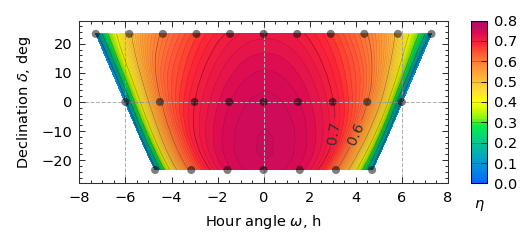

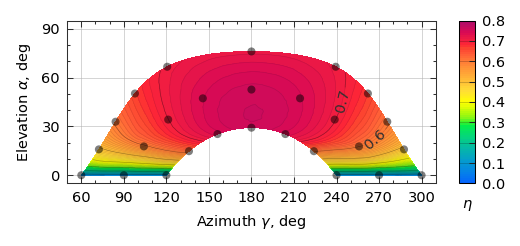

In [9]:
# contour plots for reference efficiency
figure = sunPlotter.showEquatorial(etaRef)
# figure.savefig(etaName + "EtaRefE.pdf", dpi=300)

figure = sunPlotter.showHorizontal(etaRef)
# figure.savefig(etaName + "EtaRefH.pdf", dpi=300)

## Interpolation

delta_rms = 2.861%
delta_m = -1.227%
delta_wm = -0.499%


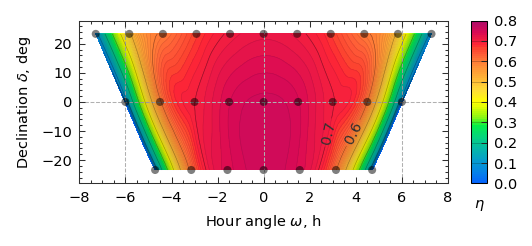

In [10]:
methodTri = sp.InterpolationMethod('triangular', order=2)
etaTri = sp.MakeInterpolation(sunSpatial, etaRef, methodTri)
sunTemporal.checkAccuracy(etaTri, etaRef)
# sunSpatial.checkAccuracy(etaTri, etaRef)
# sunSpatialPlot.checkAccuracy(etaTri, etaRef)
figure = sunPlotter.showEquatorial(etaTri)

delta_rms = 1.071%
delta_m = -0.367%
delta_wm = -0.124%


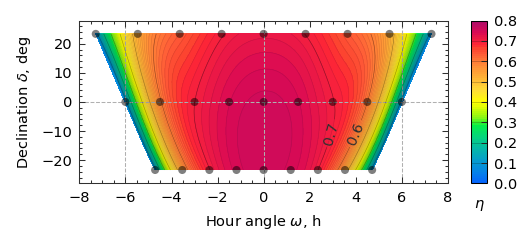

In [11]:
methodBS = sp.InterpolationMethod('B-spline', order=[3, 2])
etaBS = sp.MakeInterpolation(sunSpatialRect, etaRef, methodBS) 
sunTemporal.checkAccuracy(etaBS, etaRef)
figure = sunPlotterRect.showEquatorial(etaBS)

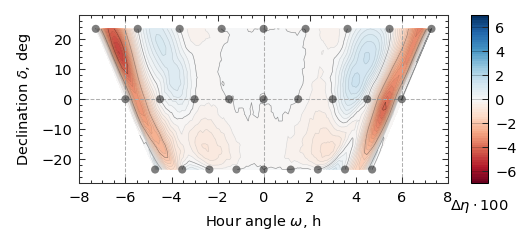

In [12]:
figure = sunPlotterRect.showEquatorial(lambda v: 100*(etaBS(v) - etaRef(v)),
    levels=[-7, 7, 2, 10], cmap=sp.cm.RdBu, cbarTitle=r"$\Delta\eta\cdot100$", labelPositions=[])
# figure.savefig(etaName + "DiffBS.pdf", dpi=300)

delta_rms = 1.457%
delta_m = -0.438%
delta_wm = -0.182%


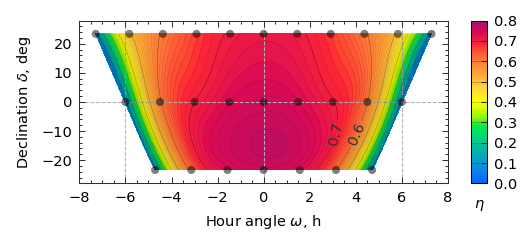

In [13]:
methodRBF2D = sp.InterpolationMethod('RBF-2D', kernel='quintic')
etaRBF2D = sp.MakeInterpolation(sunSpatial, etaRef, methodRBF2D)
sunTemporal.checkAccuracy(etaRBF2D, etaRef)
figure = sunPlotter.showEquatorial(etaRBF2D)

In [14]:
# pFunc = lambda s: 1
# pFunc = lambda s: 1 + s.z
pFunc = lambda s: math.exp(1*s.z)

delta_rms = 0.607%
delta_m = -0.182%
delta_wm = -0.095%


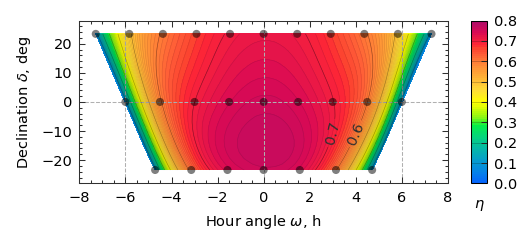

In [15]:
methodRBFg = sp.InterpolationMethod('RBF-3D', kernel='gaussian', sigma=2.3*rho, precondition=pFunc)
etaRBFg = sp.MakeInterpolation(sunSpatial, etaRef, methodRBFg)
sunTemporal.checkAccuracy(etaRBFg, etaRef)
figure = sunPlotter.showEquatorial(etaRBFg)

delta_rms = 0.500%
delta_m = 0.008%
delta_wm = 0.030%


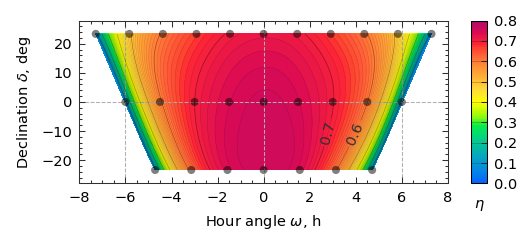

In [16]:
methodRBF = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=6, precondition=pFunc)
etaRBF = sp.MakeInterpolation(sunSpatial, etaRef, methodRBF)
sunTemporal.checkAccuracy(etaRBF, etaRef)
figure = sunPlotter.showEquatorial(etaRBF)

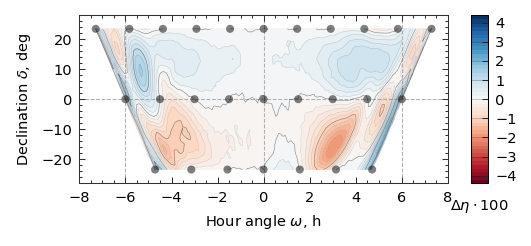

In [17]:
figure = sunPlotter.showEquatorial(lambda v: 100*(etaRBF(v) - etaRef(v)),
    levels=[-4.5, 4.5, 1, 5], cmap=sp.cm.RdBu, cbarTitle=r"$\Delta\eta\cdot100$", labelPositions=[])
# figure.savefig(etaName + "DiffRBF.pdf", dpi=300)

## Weights

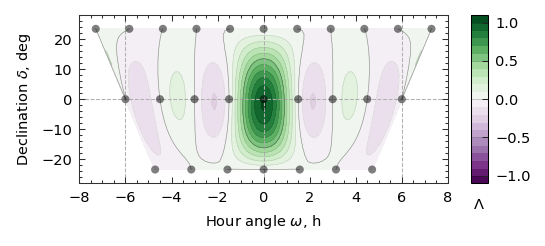

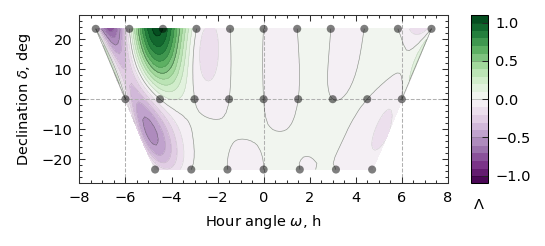

In [18]:
methodRBFn = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=6, precondition=pFunc)
for n in [11, 18]:
    methodRBFn.node = n
    etaRBFn = sp.MakeInterpolation(sunSpatial, etaRef, methodRBFn)
    figure = sunPlotter.showEquatorial(etaRBFn,     
        levels=[-1.1, 1.1, 0.5, 5], cmap=sp.cm.PRGn, cbarTitle=r"$\Lambda$", labelPositions=[])
#     figure.savefig("Lambda-" + str(n) + ".pdf", dpi=300)

In [19]:
methodRBFn = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=6, precondition=pFunc)
methodRBFn.findWeights(sunTemporal, sunSpatial, etaRef)

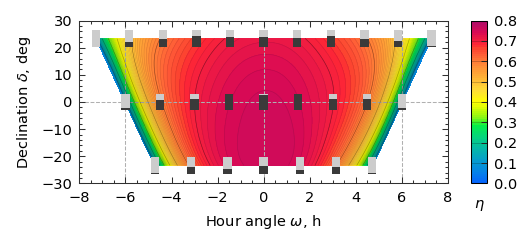

In [20]:
figure = sunPlotter.showEquatorial(etaRBF, labelPositions=[], showWeights=True)
figure.savefig("weights.pdf", dpi=300)

In [21]:
diff = methodRBFn.checkDiff(sunTemporal, sunSpatial, etaRef)
print('diff = {:.3f}%'.format(100*diff))

diff = 0.030%


In [22]:
# export sampling points
with open('sampling.csv', mode='w') as file:
    file.write("Index,   Azimuth [deg], Elevation [deg], Weight [Wh/m^2], Weight [%]\n")
    index = 0
    wTotal = np.sum(sunSpatial.nodesW) # insolation
    for ae, w in zip(sunSpatial.nodesH, sunSpatial.nodesW):
        index += 1
        text = "{:5d}, {:15.4f}, {:15.4f}, {:15.1f}, {:10.4f}\n".format(
            index, ae.azimuth()/sp.degree, ae.elevation()/sp.degree, w, 100*w/wTotal
        ) 
        file.write(text)

## Tables

In [23]:
def printDeltaRow(name, spatial, method):
    etaTri = sp.MakeInterpolation(spatial, etaRef, method)
    delta_rms, delta_m, delta_wm = sunTemporal.checkAccuracy(etaTri, etaRef, verbose=False)
    print('{:12s} {:5.3f} & {:5.3f} & {:5.3f}'.format(name, abs(delta_rms)*100, abs(delta_m)*100, abs(delta_wm)*100))

In [24]:
methodTri = sp.InterpolationMethod('triangular', order=1)
printDeltaRow('tri-1', sunSpatial, methodTri)
methodTri = sp.InterpolationMethod('triangular', order=2)
printDeltaRow('tri-2', sunSpatial, methodTri)

methodBS = sp.InterpolationMethod('B-spline', order=[2, 2])
printDeltaRow('B22', sunSpatialRect, methodBS)
methodBS = sp.InterpolationMethod('B-spline', order=[3, 2])
printDeltaRow('B32', sunSpatialRect, methodBS)
if rho < 2*sunCalculator.obliquity/2:
    methodBS = sp.InterpolationMethod('B-spline', order=[3, 3])
    printDeltaRow('B33', sunSpatialRect, methodBS)
else:
    print('B33')

for tk in ['multiquadric', 'inverse', 'gaussian', 'linear', 'thin-plate', 'cubic', 'quintic']:
    methodRBF2D = sp.InterpolationMethod('RBF-2D', kernel=tk)
    printDeltaRow(tk, sunSpatial, methodRBF2D)

for pFunc in [lambda s: 1., lambda s: 1. + s.z, lambda s: math.exp(1*s.z)]:
    for tn in [2., 2.3, 2.5]:
        methodRBFg = sp.InterpolationMethod('RBF-3D', kernel='gaussian', sigma=tn*rho, precondition=pFunc)
        printDeltaRow('gaussian ' + str(tn), sunSpatial, methodRBFg)
    for tn in [3, 4, 5, 6, 7, 8]:
        methodRBF = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=tn, precondition=pFunc)
        printDeltaRow('poly ' + str(tn), sunSpatial, methodRBF)

tri-1        4.183 & 2.523 & 1.542
tri-2        2.861 & 1.227 & 0.499
B22          1.697 & 0.571 & 0.174
B32          1.071 & 0.367 & 0.124
B33
multiquadric 3.260 & 1.149 & 0.382
inverse      4.259 & 1.494 & 0.435
gaussian     4.360 & 0.209 & 0.853
linear       4.344 & 2.211 & 1.230
thin-plate   2.870 & 1.147 & 0.676
cubic        2.343 & 0.876 & 0.449
quintic      1.457 & 0.438 & 0.182
gaussian 2.0 1.104 & 0.197 & 0.047
gaussian 2.3 1.050 & 0.171 & 0.109
gaussian 2.5 1.226 & 0.173 & 0.156
poly 3       2.414 & 0.818 & 0.325
poly 4       1.677 & 0.422 & 0.020
poly 5       1.374 & 0.376 & 0.119
poly 6       0.825 & 0.082 & 0.073
poly 7       0.660 & 0.067 & 0.037
poly 8       1.326 & 0.110 & 0.071
gaussian 2.0 0.778 & 0.168 & 0.043
gaussian 2.3 0.594 & 0.153 & 0.079
gaussian 2.5 0.645 & 0.157 & 0.105
poly 3       1.540 & 0.584 & 0.266
poly 4       1.168 & 0.341 & 0.051
poly 5       0.836 & 0.255 & 0.085
poly 6       0.595 & 0.001 & 0.053
poly 7       0.434 & 0.033 & 0.018
poly 8       1.4